In [1]:
# brew install libomp
# pip install lightgbm

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

/Library/Python/3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Correlation analysis

In [3]:
df = pd.read_csv('./data/output/result_gemeente.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6508 non-null   int64  
 1   last_scraped                 6508 non-null   object 
 2   host_id                      6508 non-null   int64  
 3   host_since                   6508 non-null   object 
 4   host_is_superhost            6508 non-null   int64  
 5   neighbourhood_cleansed       6508 non-null   object 
 6   host_listings_count          6508 non-null   int64  
 7   latitude                     6508 non-null   float64
 8   longitude                    6508 non-null   float64
 9   property_type                6508 non-null   object 
 10  room_type                    6508 non-null   object 
 11  accommodates                 6508 non-null   int64  
 12  bathrooms                    6508 non-null   float64
 13  bathrooms_text    

## 1. Correlation of Columns with Price

In [5]:
# One hot encoding for property category
df = pd.get_dummies(df, columns=['property_category'], prefix=['type'])

In [6]:
# Convert distance columns to float
distance_columns = [
    'trainstation_distance', 'amusement_park_distance', 'swimming_pool_distance',
    'cinema_distance', 'museum_distance',  'supermarket_distance', 'cafe_distance', 'hotel_distance', 'restaurant_distance',
]
for column in distance_columns:
    df[column] = df[column].str.replace(',', '.').astype(float)

In [7]:
features = ["host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds",
            "number_of_reviews", "review_scores_rating", 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "residents", "average_household_income", "average_house_value", "supermarket_distance", "cafe_distance",
            "hotel_distance", "restaurant_distance", "trainstation_distance", "amusement_park_distance",
            "swimming_pool_distance", "cinema_distance", "museum_distance",
            'distance_to_city_center', "type_PRIVATE_ROOM", "type_WHOLE_PROPERTY"]

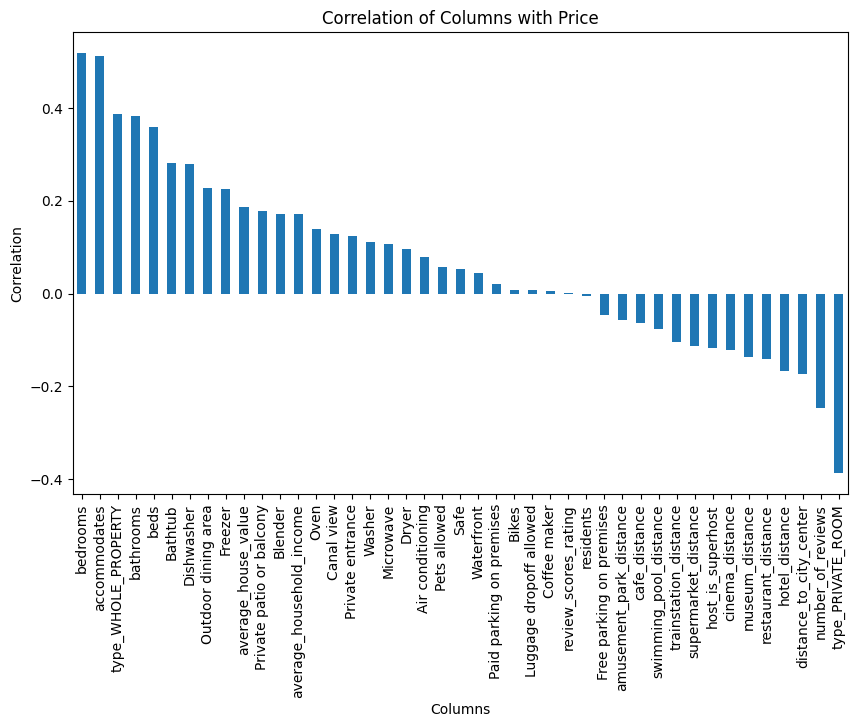

In [8]:
df_correlation = df[features]
corr_matrix = df_correlation.corr()

price_corr = df_correlation.corrwith(df['price']).sort_values(ascending=False)
price_corr.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation of Columns with Price')
plt.ylabel('Correlation')
plt.xlabel('Columns')
plt.show()

## 2. Feature importance


In [9]:
features = (["distance_to_city_center", "price", "host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds",
            "number_of_reviews", "review_scores_rating", 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "residents", "average_household_income", "average_house_value", "supermarket_distance", "cafe_distance",
            "hotel_distance", "restaurant_distance", "trainstation_distance", "amusement_park_distance",
            "swimming_pool_distance", "cinema_distance", "museum_distance", "type_WHOLE_PROPERTY"])

In [10]:
df_clean = df[features]
df_clean = df_clean.dropna()
df_clean['log_price'] = np.log(df_clean['price'])

X = df_clean.drop(columns=['price', 'log_price'])
y = df_clean['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',  # Since we are predicting a continuous value
    'metric': 'rmse',  # Root Mean Squared Error (RMSE)
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to be used for building trees
}

lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=200)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration,
                           callbacks=[
                               lgb.early_stopping(stopping_rounds=100),
                           ])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 5200, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.431180
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x15ee88b20>


In [11]:
# 5. Evaluate the Model

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

# Get number of observations (n) and number of features (p)
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features (predictors)

# Calculate Adjusted R²
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print(f'Adjusted R²: {r2_adj}')

RMSE: 0.09969907753709169
R²: 0.6284168110139845
Adjusted R²: 0.616001143601564


In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.24112057207762405


In [13]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.09969907753709169


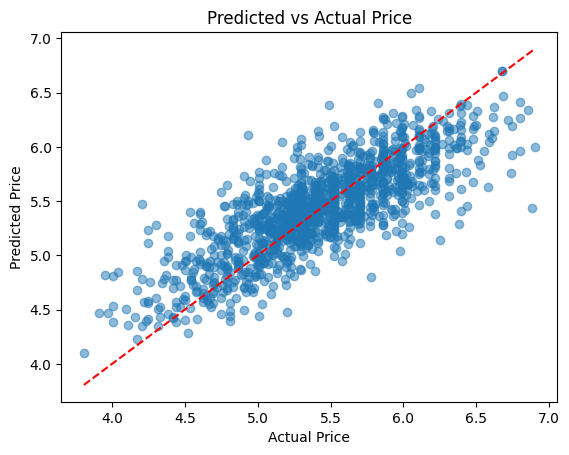

In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

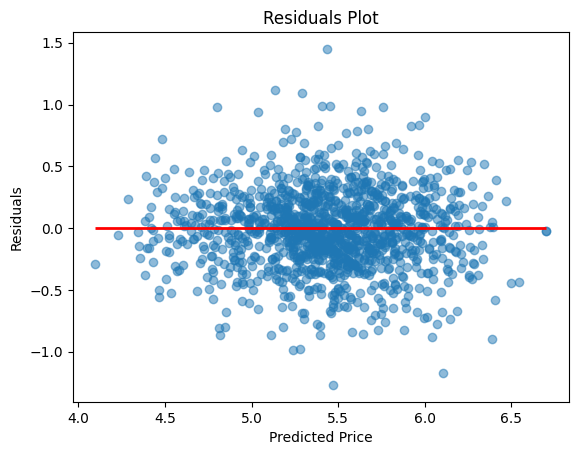

In [15]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

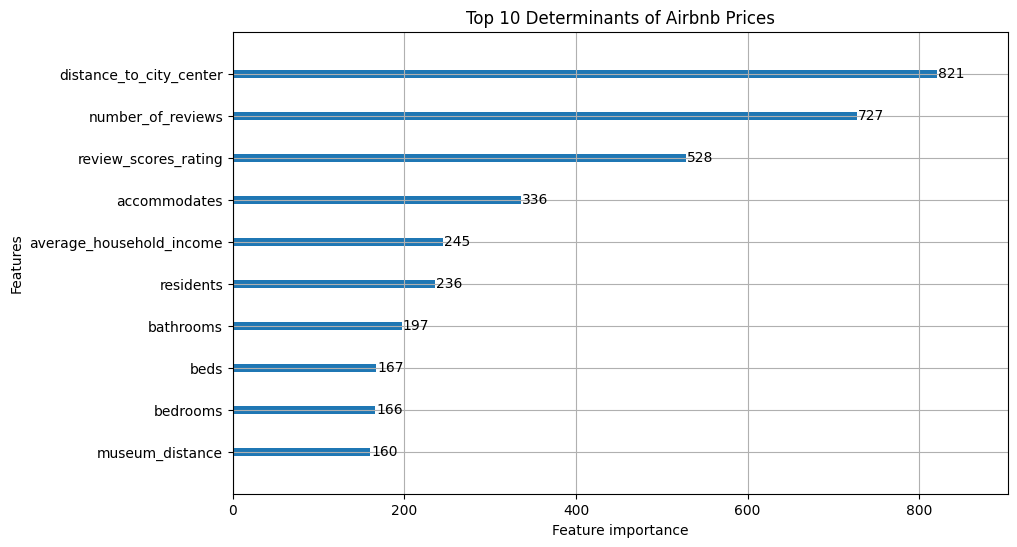

In [16]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title('Top 10 Determinants of Airbnb Prices')
plt.show()

## Shap

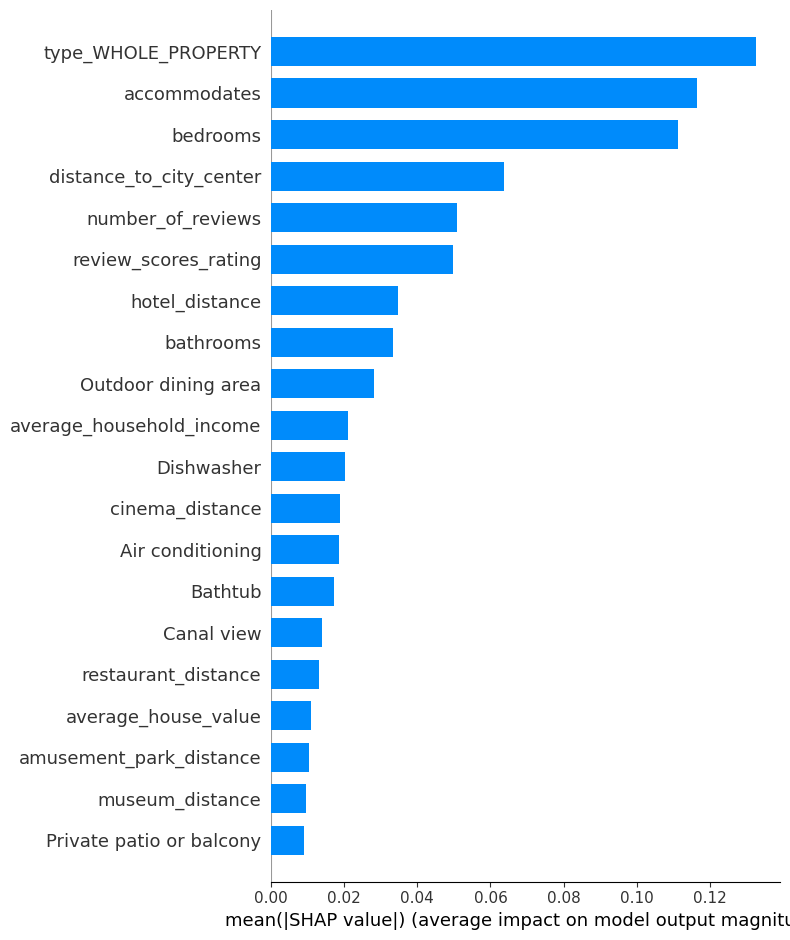

In [17]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type='bar')


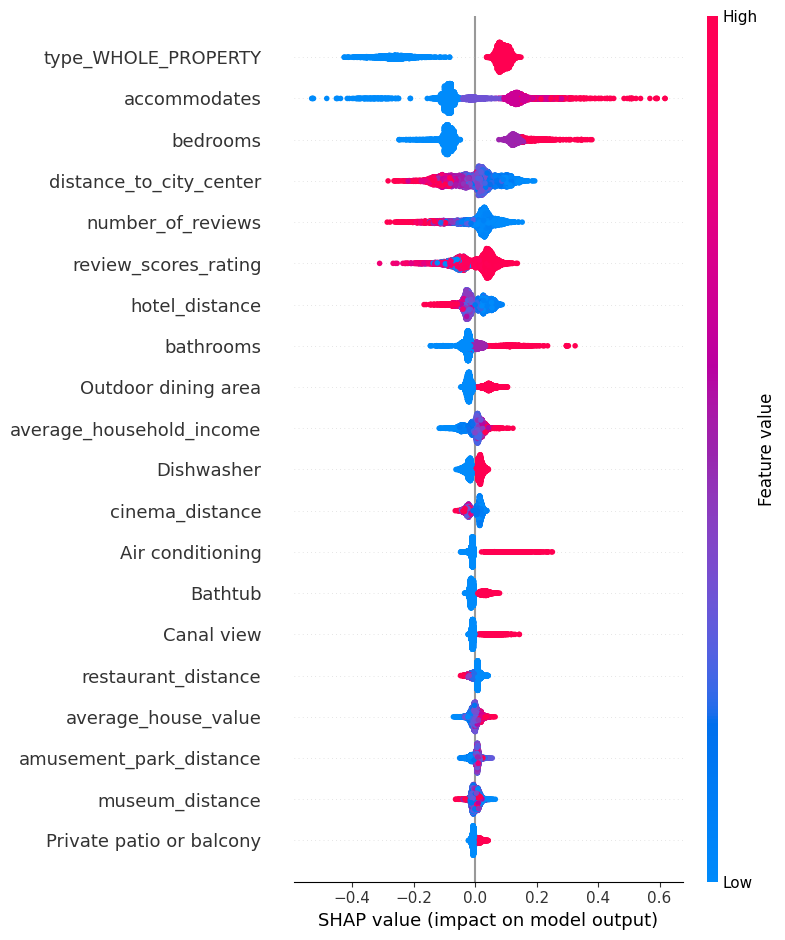

In [18]:
shap.summary_plot(shap_values, X_train)

## AIC and BIC

In [19]:
from scipy.stats import norm

def calculate_log_likelihood(y_true, y_pred, sigma):
    return np.sum(norm.logpdf(y_true, loc=y_pred, scale=sigma))

lgb_sigma = np.sqrt(mean_squared_error(y_test, y_pred))
lgb_log_likelihood = calculate_log_likelihood(y_test, y_pred, lgb_sigma)
lgb_params = lgb_model.best_iteration
lgb_aic = 2 * lgb_params - 2 * lgb_log_likelihood
lgb_bic = np.log(len(y_test)) * lgb_params - 2 * lgb_log_likelihood

print(f"LightGBM AIC: {lgb_aic}, BIC: {lgb_bic}")

LightGBM AIC: 691.9616755557422, BIC: 691.9616755557422
